In [ ]:
#!pip install nltk
!pip install shap
!pip install lime
!pip install sage-importance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 15.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=bea52d5c4e89ae0ad241acfb8c4c2e6320c323ed09b47da274197e64f8040bd2
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import Libraries 
from collections.abc import Iterable
import nltk
nltk.download('punkt')
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.utils import pad_sequences
from keras.layers import LSTM, InputLayer, Dense, Embedding, Dropout,SpatialDropout1D, Bidirectional, TimeDistributed, Activation, Masking, Lambda
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from keras.models import load_model
# suppress the UndefinedMetricWarning message
import warnings
warnings.filterwarnings('ignore')
import shap
import lime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the CoNLL2003 dataset
def load_data(file_path):
    data = open(file_path).read()
    sentences = data.strip().split('\n\n')
    tokens = []
    pos_tags = []
    ner_tags = []
    for sentence in sentences:
        lines = sentence.strip().split('\n')
        token_list = []
        pos_tag_list = []
        ner_tag_list = []
        for line in lines:
            parts = line.strip().split(' ')
            token_list.append(parts[0])
            pos_tag_list.append(parts[1])
            ner_tag_list.append(parts[3])
        tokens.append(token_list)
        pos_tags.append(pos_tag_list)
        ner_tags.append(ner_tag_list)
    return tokens, pos_tags, ner_tags

In [ ]:
tokens_train, pos_tags_train, ner_tags_train = load_data('/content/drive/MyDrive/data/eng.train')
tokens_testa, pos_tags_testa, ner_tags_testa = load_data('/content/drive/MyDrive/data/eng.testa')
tokens_testb, pos_tags_testb, ner_tags_testb = load_data('/content/drive/MyDrive/data/eng.testb')

In [ ]:
# import pandas as pd

# # Load the data
# tokens_train, pos_tags_train, ner_tags_train = load_data('eng.train')
# tokens_testa, pos_tags_testa, ner_tags_testa = load_data('eng.testa')
# tokens_testb, pos_tags_testb, ner_tags_testb = load_data('eng.testb')

# # Create a list of sentences by joining the words
# sentences_train = [' '.join(sentence) for sentence in tokens_train]
# sentences_testa = [' '.join(sentence) for sentence in tokens_testa]
# sentences_testb = [' '.join(sentence) for sentence in tokens_testb]
# # Create a DataFrame with the sentences and tags
# sentences = sentences_train + sentences_testa + sentences_testb
# pos_tags = pos_tags_train + pos_tags_testa + pos_tags_testb
# ner_tags = ner_tags_train + ner_tags_testa + ner_tags_testb

# # Create the DataFrame
# ENG_TRAIN = pd.DataFrame({
#     'sentence': sentences,
#     'pos_tags': pos_tags,
#     'ner_tags': ner_tags
# })
# #NAHRADENIE POS_TAGS PODLA DICT 
# for i in range(len(ENG_TRAIN)):
#     for j in range(len(ENG_TRAIN.loc[i, 'pos_tags'])):
#         for key, value in pos_tag_groups.items():
#             if ENG_TRAIN.loc[i, 'pos_tags'][j] in value:
#                 ENG_TRAIN.loc[i, 'pos_tags'][j] = key
#                 break
# import ast
# dsssf = ENG_TRAIN[['pos_tags', 'ner_tags']].copy()
# dsssf['pos_tags'] = dsssf['pos_tags'].apply(lambda x: ast.literal_eval(str([tag if ',' not in tag else None for tag in x])))
# dsssf['ner_tags'] = dsssf['ner_tags'].apply(lambda x: ast.literal_eval(str([tag if ',' not in tag else None for tag in x])))
# dsssf = dsssf.explode(['pos_tags', 'ner_tags'])
# dsssf.to_csv('dsssf.csv', index=False)
# dsssf = pd.read_csv('dsssf.csv')
# df = ENG_TRAIN
# # Split the sentences and create a new dataframe
# split_df = pd.DataFrame(df['sentence'].str.split().tolist(), index=df.index).stack().reset_index()
# split_df.columns = ['index', 'word_id', 'word']
# # Add the hashtag column
# split_df['hashtag'] = 'Sentence:' + (split_df['index'] + 1).astype(str)
# # Remove the old 'index' column
# split_df = split_df.drop(columns='index')
# split_df.to_csv('train.csv', index=False)
# split_train = split_df
# data = pd.concat([split_train[['word', 'hashtag']], dsssf], axis=1)
# data.to_csv('SPOLU_DATA.csv', index=False)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/SPOLU_DATA.xls', encoding="latin1")
data.head()

,Word,Sentence #,POS,Tag
0,-DOCSTART-,Sentence:1,-X-,O
1,EU,Sentence:2,NN,I-ORG
2,rejects,Sentence:2,VB,O
3,German,Sentence:2,JJ,I-MISC
4,call,Sentence:2,NN,O


In [ ]:
data = data.rename(columns={'Word': 'word'})


In [ ]:
data['word'] = data['word'].astype(str)

In [ ]:
data = data[~data['word'].str.contains("-DOCSTART-")]

In [ ]:
class SentenceGetter:
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        self.sentences = self.group_sentences(data)

    def group_sentences(self, data):
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        grouped = data.groupby("Sentence #").apply(agg_func)
        return [s for s in grouped]

    def get_next(self):
        try:
            sentence = self.sentences[self.n_sent - 1]
            self.n_sent += 1
            return sentence
        except IndexError:
            return None

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
ner = [[s[2] for s in sent] for sent in sentences]
pos = [[s[1] for s in sent] for sent in sentences]
sentences = [" ".join(s[0] for s in sent) for sent in sentences]

In [ ]:
index = 2

def print_sentence_with_pos_and_ner(sentences, pos, ner, index):
    # Print the specified sentence with its POS and NER tags
    print("Sentence: ", sentences[index])
    print("POS: ", pos[index])
    print("NER: ", ner[index])

print_sentence_with_pos_and_ner(sentences, pos, ner, index)

Sentence:  * Reinsurance group Scor gained 2.1 percent to 202 francs on news that British insurer Prudential had sold its Mercantile & General reinsurance business to Swiss Re .
POS:  ['SYM', 'NN', 'NN', 'NN', 'VB', 'CD', 'NN', 'TO', 'CD', 'NN', 'IN', 'NN', 'IN', 'JJ', 'NN', 'NN', 'VB', 'VB', 'PRP', 'NN', 'CC', 'NN', 'NN', 'NN', 'TO', 'NN', 'NN', '.']
NER:  ['O', 'O', 'O', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'I-ORG', 'O', 'O', 'O', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'I-MISC', 'I-ORG', 'O']


In [ ]:
# Get the length of each sentence
sent_lengths = [len(sent.split()) for sent in sentences]

# Find the index of the shortest and longest sentences
shortest_idx = sent_lengths.index(min(sent_lengths))
longest_idx = sent_lengths.index(max(sent_lengths))

# Print the shortest sentence and its POS and NER tags
print("Najkratšia veta v dátovej množine:")
print_sentence_with_pos_and_ner(sentences, pos, ner, shortest_idx)

# Print the longest sentence and its POS and NER tags
print("Najdlhšia veta v dátovej množine:")
print_sentence_with_pos_and_ner(sentences, pos, ner, longest_idx)

Najkratšia veta v dátovej množine:
Sentence:  ---
POS:  ['SYM']
NER:  ['O']
Najdlhšia veta v dátovej množine:
Sentence:  Barbarians - 15 - Tim Stimpson ( England ) ; 14 - Nigel Walker ( Wales ) , 13 - Allan Bateman ( Wales ) , 12 - Gregor Townsend ( Scotland ) , 11 - Tony Underwood ( England ) ; 10 - Rob Andrew ( England ) , 9 - Rob Howley ( Wales ) ; 8 - Scott Quinnell ( Wales ) , 7 - Neil Back ( England ) , 6 - Dale McIntosh ( Pontypridd ) , 5 - Ian Jones ( New Zealand ) , 4 - Craig Quinnell ( Wales ) , 3 - Darren Garforth ( Leicester ) , 2 - Norm Hewitt ( New Zealand ) , 1 - Nick Popplewell ( Ireland ) .
POS:  ['NN', ':', 'CD', ':', 'NN', 'NN', '(', 'NN', ')', ':', 'CD', ':', 'NN', 'NN', '(', 'NN', ')', nan, 'CD', ':', 'NN', 'NN', '(', 'NN', ')', nan, 'CD', ':', 'NN', 'NN', '(', 'NN', ')', nan, 'CD', ':', 'NN', 'NN', '(', 'NN', ')', ':', 'CD', ':', 'NN', 'NN', '(', 'NN', ')', nan, 'CD', ':', 'NN', 'NN', '(', 'NN', ')', ':', 'CD', ':', 'NN', 'NN', '(', 'NN', ')', nan, 'CD', ':', 'NN'

In [ ]:
# Count the number of words in the shortest sentence
shortest_words = sentences[shortest_idx].split()
num_shortest_words = len(shortest_words)

# Count the number of words in the longest sentence
longest_words = sentences[longest_idx].split()
num_longest_words = len(longest_words)

# Print the results
print("Počet slov v najkratšej vete:", num_shortest_words)
print("Počet slov v najdlhšej vete:", num_longest_words)

Počet slov v najkratšej vete: 1
Počet slov v najdlhšej vete: 124


In [ ]:
# define list function 
def create_list(tokens):
    token_list = []
    for sentence in tokens:
        for token in sentence:
            token_list.append(token)
    return token_list

In [ ]:
# Create token and tag lists
tokens_train_list = create_list(tokens_train)
tokens_testa_list = create_list(tokens_testa)
tokens_testb_list = create_list(tokens_testb)

pos_tags_train_list = create_list(pos_tags_train)
pos_tags_testa_list = create_list(pos_tags_testa)
pos_tags_testb_list = create_list(pos_tags_testb)

ner_tags_train_list = create_list(ner_tags_train)
ner_tags_testa_list = create_list(ner_tags_testa)
ner_tags_testb_list = create_list(ner_tags_testb)

In [ ]:
# Create unique tokens and tags vocab
tokens_vocab = list(set(tokens_train_list + tokens_testa_list + tokens_testb_list))
pos_tag_vocab = list(set(pos_tags_train_list + pos_tags_testa_list + pos_tags_testb_list))
ner_tag_vocab = list(set(ner_tags_train_list + ner_tags_testa_list + ner_tags_testb_list))

In [ ]:
# Map each token, POS tag, and NER tag to a numerical value
token2idx = {token: i + 1 for i, token in enumerate(tokens_vocab)}
ner_tag2idx = {ner_tag: i + 1 for i, ner_tag in enumerate(ner_tag_vocab)}
ner_tag2idx['<PAD>'] = 0

In [ ]:
# Convert the tokens, POS tags, and NER tags to numerical values
X_train = [[token2idx[token] for token in sentence] for sentence in tokens_train]
y_ner_train = [[ner_tag2idx[ner_tag] for ner_tag in sentence] for sentence in ner_tags_train]

X_testa = [[token2idx[token] for token in sentence] for sentence in tokens_testa]
y_ner_testa = [[ner_tag2idx[ner_tag] for ner_tag in sentence] for sentence in ner_tags_testa]

X_testb = [[token2idx[token] for token in sentence] for sentence in tokens_testb]
y_ner_testb = [[ner_tag2idx[ner_tag] for ner_tag in sentence] for sentence in ner_tags_testb]

In [ ]:
# Pad the sequences to ensure they are all the same length
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
y_ner_train = pad_sequences(y_ner_train, maxlen=max_len, padding='post', truncating='post')

X_testa = pad_sequences(X_testa, maxlen=max_len, padding='post', truncating='post')
y_ner_testa = pad_sequences(y_ner_testa, maxlen=max_len, padding='post', truncating='post')

X_testb = pad_sequences(X_testb, maxlen=max_len, padding='post', truncating='post')
y_ner_testb = pad_sequences(y_ner_testb, maxlen=max_len, padding='post', truncating='post')

In [ ]:
# Convert the numerical values to one-hot encoded vectors
y_ner_train_enc  = to_categorical(y_ner_train, num_classes=len(ner_tag2idx) + 1)
y_ner_testa_enc  = to_categorical(y_ner_testa, num_classes=len(ner_tag2idx) + 1)
y_ner_testb_enc  = to_categorical(y_ner_testb, num_classes=len(ner_tag2idx) + 1)

In [ ]:
#Define POS model
model = Sequential()
model.add(InputLayer(input_shape=(max_len, )))
model.add(Embedding(input_dim=len(token2idx) + 1, output_dim=128, input_length=max_len, dtype='float32'))
model.add(Dropout(0.2))
model.add((LSTM(64,return_sequences=True)))
model.add(TimeDistributed(Dense(len(ner_tag2idx) + 1, activation='softmax')))
model.compile(optimizer = Adam(learning_rate = 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'],loss_weights=[0.5, 0.5])


#BEST MODEL FROM EXPERIMENTS

In [ ]:
#NER Bi-LSTM model2 with regularization: TEST A -> acc: 0,99, F1 macro:0,94 .... TEST B -> acc: 0,99, F1 macro: 0,93 
from keras.regularizers import l1, l2
model = Sequential()
model.add(InputLayer(input_shape=(max_len, )))
model.add(Embedding(input_dim=len(token2idx) + 1, output_dim=128, input_length=max_len, dtype='float32'))
model.add(Bidirectional(LSTM(128, return_sequences=True,kernel_regularizer=l2(0.0000001), recurrent_regularizer=l1(0.0000001))))
model.add((LSTM(128, return_sequences=True,kernel_regularizer=l2(0.0000001))))
model.add(TimeDistributed(Dense(len(ner_tag2idx) + 1, activation='softmax')))
model.compile(optimizer = Adam(learning_rate = 0.01),loss = 'categorical_crossentropy', metrics = ['accuracy'],loss_weights=[0.5, 0.5])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 128)          3877248   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         263168    
 nal)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 100, 128)          197120    
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 10)          1290      
 tributed)                                                       
                                                                 
Total params: 4,338,826
Trainable params: 4,338,826
Non-trainable params: 0
_________________________________________________________________


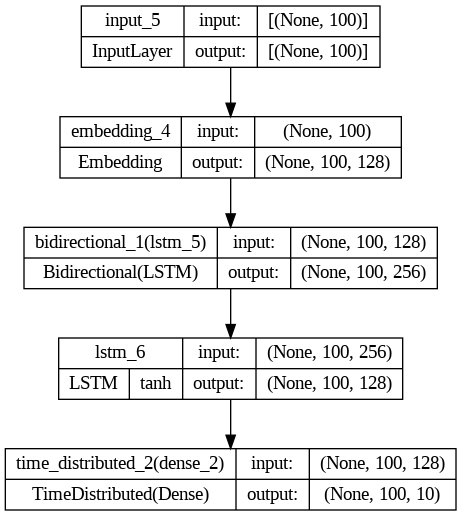

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='ner_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False
)

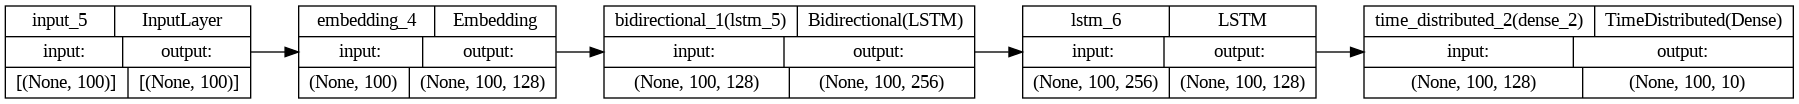

In [ ]:
# `rankdir='LR'` is to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
#import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
import time
start_time = time.time()

In [ ]:
saved_model = 'ner.hdf5'
checkpoint = ModelCheckpoint(saved_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

epochs = 10
batch_size = 64
history = model.fit(X_train, y_ner_train_enc, validation_data=(X_testa,y_ner_testa_enc), epochs=epochs, batch_size=batch_size,callbacks=[checkpoint])

Epoch 1/10
235/235 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9758
Epoch 1: val_accuracy improved from -inf to 0.99093, saving model to ner.hdf5
235/235 [==============================] - 15s 20ms/step - loss: 0.0420 - accuracy: 0.9758 - val_loss: 0.0162 - val_accuracy: 0.9909
Epoch 2/10
233/235 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.9962
Epoch 2: val_accuracy improved from 0.99093 to 0.99373, saving model to ner.hdf5
235/235 [==============================] - 4s 15ms/step - loss: 0.0076 - accuracy: 0.9962 - val_loss: 0.0121 - val_accuracy: 0.9937
Epoch 3/10
235/235 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9987
Epoch 3: val_accuracy improved from 0.99373 to 0.99443, saving model to ner.hdf5
235/235 [==============================] - 4s 16ms/step - loss: 0.0034 - accuracy: 0.9987 - val_loss: 0.0116 - val_accuracy: 0.9944
Epoch 4/10
233/235 [============================>.] - ETA: 0s - loss: 0.002

In [ ]:
end_time = time.time()
bi_lstm_training_time = end_time - start_time
print("Bi-LSTM training time:", bi_lstm_training_time)

Bi-LSTM training time: 46.62714433670044


In [ ]:
num_parameters = model.count_params()
print("Number of trainable parameters in Bi-LSTM model:", num_parameters)

Number of trainable parameters in Bi-LSTM model: 4338826


In [ ]:
def trainingProcess(history):
    plt.style.use('ggplot')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('ner_acc.png')
    plt.show()
    plt.style.use('ggplot')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('ner_loss.png')
    plt.show()

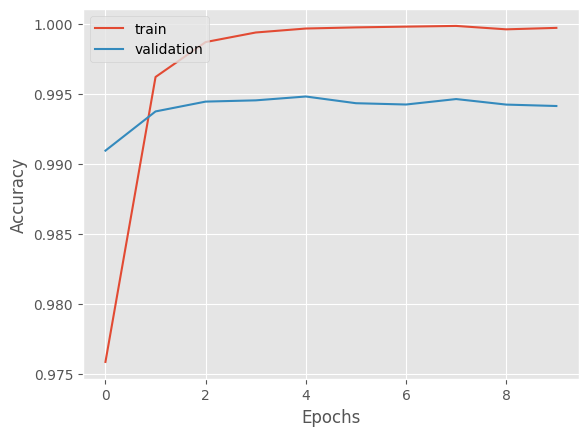

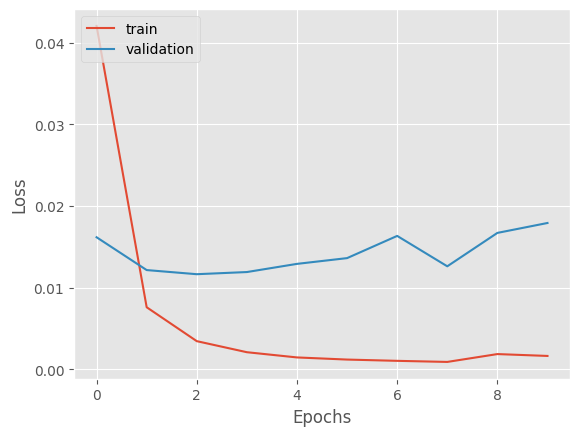

In [ ]:
trainingProcess(history)

In [ ]:
# load best model
myModel = load_model('ner.hdf5') 

In [ ]:
# Evaluate the model on the test sets
test_scores = model.evaluate(X_testa,y_ner_testa_enc)
print('\nTest set A:')
print("NER loss:, NER accuracy:", test_scores)


test_scores = model.evaluate(X_testb,y_ner_testb_enc)
print('\nTest set B:')
print("NER loss:, NER accuracy:", test_scores)

109/109 [==============================] - 1s 6ms/step - loss: 0.0179 - accuracy: 0.9941

Test set A:
NER loss:, NER accuracy: [0.01790129952132702, 0.9941142797470093]
116/116 [==============================] - 1s 6ms/step - loss: 0.0227 - accuracy: 0.9918

Test set B:
NER loss:, NER accuracy: [0.022737551480531693, 0.9918322563171387]


In [ ]:
# Evaluate the model
y_pred_ner_testa = model.predict(X_testa)
y_pred_ner_testa = np.argmax(y_pred_ner_testa, axis=-1)

# Evaluate the model
y_pred_ner_testb = model.predict(X_testb)
y_pred_ner_testb = np.argmax(y_pred_ner_testb, axis=-1)

116/116 [==============================] - 1s 5ms/step


In [ ]:
# Evaluation Results of Test A Set
print('Test A Set')
print('Accuracy score:', accuracy_score(y_ner_testa.flatten(), y_pred_ner_testa.flatten()))
print('Precision score:', precision_score(y_ner_testa.flatten(), y_pred_ner_testa.flatten(), average='macro'))
print('Recall score:', recall_score(y_ner_testa.flatten(), y_pred_ner_testa.flatten(), average='weighted'))
print('F1 micro score:', f1_score(y_ner_testa.flatten(), y_pred_ner_testa.flatten(), average='micro'))
print('F1 macro score:', f1_score(y_ner_testa.flatten(), y_pred_ner_testa.flatten(), average='macro'))
#print('ROC AUC score:', roc_auc_score(y_ner_testa.flatten(), y_pred_ner_testa.flatten(), multi_class='ovr'))
print('Confusion matrix:\n', confusion_matrix(y_ner_testa.flatten(), y_pred_ner_testa.flatten()))

Test A Set
Accuracy score: 0.9941142527409117
Precision score: 0.8674815796973565
Recall score: 0.9941142527409117
F1 micro score: 0.9941142527409117
F1 macro score: 0.8305854121198422
Confusion matrix:
 [[295035      1      0      0      0      0      0]
 [     0  42810     76     19      0     13     49]
 [     0    317   1704     23      0     18     30]
 [     0    224    131   1678      1     33     27]
 [     0      1      0      0      2      1      0]
 [     0    246     38      4      2    957     17]
 [     2    709     44     10      0      4   2374]]


In [ ]:
print('Classification report:\n', classification_report(y_ner_testa.flatten(), y_pred_ner_testa.flatten(), target_names=ner_tag2idx))


ValueError: ignored

In [ ]:
# Evaluation Results of Test B Set
print('Test B Set')
print('Accuracy score:', accuracy_score(y_ner_testb.flatten(), y_pred_ner_testb.flatten()))
print('Precision score:', precision_score(y_ner_testb.flatten(), y_pred_ner_testb.flatten(), average='macro'))
print('Recall score:', recall_score(y_ner_testb.flatten(), y_pred_ner_testb.flatten(), average='weighted'))
print('F1 micro score:', f1_score(y_ner_testb.flatten(), y_pred_ner_testb.flatten(), average='micro'))
print('F1 macro score:', f1_score(y_ner_testb.flatten(), y_pred_ner_testb.flatten(), average='macro'))
#print('ROC AUC score:', roc_auc_score(y_ner_testa.flatten(), y_pred_ner_testa.flatten(), multi_class='ovr'))
print('Confusion matrix:\n', confusion_matrix(y_ner_testb.flatten(), y_pred_ner_testb.flatten()))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the list of labels from token2idx dictionary
labels = list(ner_tag2idx.keys())

# Create the confusion matrix
cm = confusion_matrix(y_ner_testb.flatten(), y_pred_ner_testb.flatten())

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Kontingenčná tabuľka')
plt.savefig('NER_CM.png')
plt.show()

In [ ]:
# Classification report
print('Classification report for test B set:\n', classification_report(y_ner_testb.flatten(), y_pred_ner_testb.flatten(), target_names = list(ner_tag2idx.keys())))

##Feature importance for LSTM network

In [ ]:
lstm_layer = model.layers[1] # get the LSTM layer
lstm_weights = lstm_layer.get_weights()[0] # get the LSTM weights
actual_importance = np.abs(lstm_weights).sum(axis=1) # calculate the importance of each input feature

In [ ]:
feature_names = list(token2idx.keys())

In [ ]:
# Create an empty DataFrame to store the feature names and importance scores
lstm_feature_importance = pd.DataFrame(columns=["Feature", "Importance"])

# Sort the features by importance in descending order
lstm_importance_ranking = np.argsort(actual_importance)[::-1]

# Loop through the sorted features and add them to the DataFrame
for i, feature_idx in enumerate(lstm_importance_ranking):
    feature_name = feature_names[feature_idx]
    importance_score = actual_importance[feature_idx]
    lstm_feature_importance.loc[i] = [feature_name, importance_score]
# Print the DataFrame
lstm_feature_importance.sort_values(by = 'Importance', ascending=True)

In [ ]:
lstm_feature_importance['normalized_importance'] = lstm_feature_importance['Importance'] / lstm_feature_importance['Importance'].sum()

In [ ]:
lstm_feature_importance

In [ ]:
# Get the penultimate layer of the model
penultimate_layer = myModel.layers[-2]

# Print the name and output shape of the penultimate layer
print("Penultimate layer name:", penultimate_layer.name)
print("Penultimate layer output shape:", penultimate_layer.output_shape)

## XAI METHODS

###LIME


In [ ]:
#EXPLANATION OF ONE SENTENCE WITH LIME
import pandas as pd
from lime.lime_text import LimeTextExplainer

class ExplainerGenerator:
    def __init__(self, model, token2idx, ner_tag2idx, max_len):
        self.model = model
        self.token2idx = token2idx
        self.ner_tag2idx = ner_tag2idx
        self.idx2tag = {v: k for k, v in ner_tag2idx.items()}
        self.max_len = max_len

    def _preprocess(self, texts):
        sentences = [sentence.split() for sentence in texts]
        X = [
        [self.token2idx.get(token, self.token2idx['<UNK>']) for token in sentence]
         for sentence in sentences
]
        X = pad_sequences(maxlen=self.max_len, sequences=X, padding="post", truncating='post')
        return X

    def get_predict_function(self, word_index):
        def predict_func(texts):
            X = self._preprocess(texts)
            p = self.model.predict(X)
            return p[:, word_index, :]

        return predict_func


index = 256
ner_idx = ner[index]
sentence_text = sentences[index]

print('Sentence without NER:')
print(sentence_text)
print('Sentence with NER:')
print(" ".join([f"{t} ({l})" for t, l in zip(sentence_text.split(), ner_idx)]))

for i, word in enumerate(sentence_text.split()):
    print(f"{i}: {word}")

explainer_generator = ExplainerGenerator(model, token2idx, ner_tag2idx, max_len)
word_index = 6
predict_func = explainer_generator.get_predict_function(word_index=word_index)

explainer = LimeTextExplainer(class_names=ner_tag2idx)

exp = explainer.explain_instance(sentences[256], predict_func, distance_metric='cosine')
print(exp.as_list())
exp.show_in_notebook(text=True)


In [ ]:
#EXPLANATION FOR ONE WORD IN SENTENCE 
class ExplainerGenerator:
    def __init__(self, model, token2idx, ner_tag2idx, max_len):
        self.model = model
        self.token2idx = token2idx
        self.ner_tag2idx = ner_tag2idx
        self.idx2tag = {v: k for k, v in ner_tag2idx.items()}
        self.max_len = max_len

    def _preprocess(self, texts):
        sentences = [sentence.split() for sentence in texts]
        X = [
            [self.token2idx.get(token, self.token2idx['<UNK>']) for token in sentence]
            for sentence in sentences
        ]
        X = pad_sequences(maxlen=self.max_len, sequences=X, padding="post", truncating='post')
        return X

    def _explain_word(self, sentence, word_index, predict_func):
        words = sentence.split()
        word = words[word_index]
        explainer = LimeTextExplainer(class_names=list(self.ner_tag2idx.keys()))
        exp = explainer.explain_instance(sentence, predict_func, num_features=10, labels=list(self.ner_tag2idx.values()), 
                                         top_labels=1, distance_metric='cosine')
        label_idx = exp.top_labels[0]
        label = self.idx2tag[label_idx]
        return word, label, exp.as_list(label_idx)

    def get_predict_function(self, word_index):
        def predict_func(texts):
            X = self._preprocess(texts)
            p = self.model.predict(X)
            return p[:, word_index, :]

        return predict_func

explainer_generator = ExplainerGenerator(model, token2idx, ner_tag2idx, max_len)
word_index = 6
predict_func = explainer_generator.get_predict_function(word_index=word_index)
word, label, word_explanation = explainer_generator._explain_word(sentences[256], word_index, predict_func)
print(f"Word: {word}, Label: {label}, Explanation: {word_explanation}")


In [ ]:
#EXPLANATION FOR EACH WORD IN SENTENCE 

class ExplainerGenerator:
    def __init__(self, model, token2idx, ner_tag2idx, max_len):
        self.model = model
        self.token2idx = token2idx
        self.ner_tag2idx = ner_tag2idx
        self.idx2tag = {v: k for k, v in ner_tag2idx.items()}
        self.max_len = max_len

    def _preprocess(self, texts):
        sentences = [sentence.split() for sentence in texts]
        X = [
            [self.token2idx.get(token, self.token2idx['<UNK>']) for token in sentence]
            for sentence in sentences
        ]
        X = pad_sequences(maxlen=self.max_len, sequences=X, padding="post", truncating='post')
        return X

    def _explain_word(self, sentence, word_index, predict_func):
        words = sentence.split()
        word = words[word_index]
        explainer = LimeTextExplainer(class_names=list(self.ner_tag2idx.keys()))
        exp = explainer.explain_instance(sentence, predict_func, num_features=10, labels=list(self.ner_tag2idx.values()), 
                                         top_labels=1, distance_metric='cosine')
        label_idx = exp.top_labels[0]
        label = self.idx2tag[label_idx]
        return word, label, exp.as_list(label_idx)

    def explain_sentence(self, sentence):
        predict_functions = [self.get_predict_function(i) for i in range(len(sentence.split()))]
        explanations = [self._explain_word(sentence, i, pf) for i, pf in enumerate(predict_functions)]
        return explanations

    def get_predict_function(self, word_index):
        def predict_func(texts):
            X = self._preprocess(texts)
            p = self.model.predict(X)
            return p[:, word_index, :]

        return predict_func

explainer_generator = ExplainerGenerator(model, token2idx, ner_tag2idx, max_len)
sentence = sentences[256]
explanations = explainer_generator.explain_sentence(sentence)
for word, label, word_explanation in explanations:
    print(f"Word: {word}, Label: {label}, Explanation: {word_explanation}")


In [ ]:
# TEST SET FOR SURROGATE MODEL
#Create a reverse mapping for the token2idx and ner_tag2idx dictionaries
idx2token = {i+1: token for i, token in enumerate(tokens_vocab)}
idx2ner_tag = {i+1: ner_tag for i, ner_tag in enumerate(ner_tag_vocab)}

# Add mapping for padding value to token2idx dictionary
token2idx['<PAD>'] = 0

# Convert the numerical values in X_testa and y_ner_testa back to their original token and tag values
sentences_testb = []
tags_testb = []
for sentence, tag_sequence in zip(X_testb, y_ner_testb):
    sent = []
    tags = []
    for idx, tag_idx in zip(sentence, tag_sequence):
        if idx == 0:
            continue
        sent.append(idx2token[idx])
        tags.append(idx2ner_tag[tag_idx])
    sentences_testb.append(" ".join(sent))
    tags_testb.append(tags)

# Print the sentences and their respective tags
for i in range(len(sentences_testb)):
    print("Sentence: ", sentences_testb[i])
    print("True tags: ", tags_testb[i])


In [ ]:
#storing the results and som adjsutments
import pandas as pd
from lime.lime_text import LimeTextExplainer

class ExplainerGenerator:
    def __init__(self, model, token2idx, ner_tag2idx, max_len):
        self.model = model
        self.token2idx = token2idx
        self.ner_tag2idx = ner_tag2idx
        self.idx2tag = {v: k for k, v in ner_tag2idx.items()}
        self.max_len = max_len

    def _preprocess(self, texts):
        sentences = [sentence.split() for sentence in texts]
        X = [
            [self.token2idx.get(token, self.token2idx['<UNK>']) for token in sentence]
            for sentence in sentences
        ]
        X = pad_sequences(maxlen=self.max_len, sequences=X, padding="post", truncating='post')
        return X

    def _explain_word(self, sentence, word_index, predict_func):
        words = sentence.split()
        word = words[word_index]
        explainer = LimeTextExplainer(class_names=list(self.ner_tag2idx.keys()),kernel_width=1)
        exp = explainer.explain_instance(sentence, predict_func, num_features=10, labels=list(self.ner_tag2idx.values()), 
                                         top_labels=1, distance_metric='cosine',num_samples=100)
        label_idx = exp.top_labels[0]
        label = self.idx2tag[label_idx]
        return word, label, exp.as_list(label_idx)

    def explain_sentence(self, sentence):
        predict_functions = [self.get_predict_function(i) for i in range(len(sentence.split()))]
        explanations = [self._explain_word(sentence, i, pf) for i, pf in enumerate(predict_functions)]
        return explanations

    def get_predict_function(self, word_index):
        def predict_func(texts):
            X = self._preprocess(texts)
            p = self.model.predict(X)
            return p[:, word_index, :]

        return predict_func

explainer_generator = ExplainerGenerator(model, token2idx, ner_tag2idx, max_len)
results = []

for sentence_index, sentence_text in enumerate(sentences_testb):
    word_count = len(sentence_text.split())

    if word_count < 2:
        continue
    
    explanations = explainer_generator.explain_sentence(sentence_text)
    print("Processing sentence ", sentence_index+1, " out of ", len(sentences_testb))
    
    for word_index, (word, label, word_explanation) in enumerate(explanations):
        pos_count = 0
        neg_count = 0
        weights = []
        words = []
        
        for feature, weight in word_explanation:
            words.append(feature)
            weights.append(weight)
            if weight >= 0:
                pos_count += 1
            else:
                neg_count += 1
                
        row = {"sentence_index": sentence_index, "word_index": word_index, "word": word, "word_count": word_count, 
               "positive_count": pos_count, "negative_count": neg_count, "sentiment_score": sum(weights), 
               "predicted_tag": label, "important_words": words, "weights": weights}
        
        results.append(row)

results_df = pd.DataFrame(results, columns=["sentence_index", "word_index", "word", "word_count", "positive_count", 
                                             "negative_count", "sentiment_score", "predicted_tag", "important_words", "weights"])


In [ ]:
results_df=pd.read_csv('ner_testb.csv')

In [ ]:
results_df.to_csv('ner_testb.csv', index=False)

In [ ]:
from google.colab import files

# Assuming you have a file named "example.txt" in your current working directory in Colab
files.download('ner_testb.csv')

In [ ]:
#y_pred_bilstm = np.round(model.predict(y_pred_ner_testb)[:, -1]).reshape(-1)
y_pred_bilstm = y_pred_bilstm.flatten

In [ ]:
f1

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
#Encoder
from sklearn.preprocessing import LabelEncoder

# Function to plot F1 score as a function of number of samples
def plot_f1_score(model, X_test, y_test):
    f1_scores = []
    num_samples = range(100, len(X_test), 100)
    for n in num_samples:
        y_pred = model.predict(X_test[:n]).argmax(axis=-1)
        f1 = f1_score(y_test[:n].flatten(), y_pred.flatten(), average='macro')
        f1_scores.append(f1)
    plt.plot(num_samples, f1_scores, label='BiLSTM')

# Create a dictionary to map the sentence indices to their corresponding Lime labels
lime_labels_dict = {}
for i, row in results_df.iterrows():
    if row['word_count'] < 2:
        continue
    sentence_index = row['sentence_index']
    if sentence_index not in lime_labels_dict:
        lime_labels_dict[sentence_index] = []
    lime_labels_dict[sentence_index].append(row['predicted_tag'])

# Create lists of true and Lime labels for the included sentences
true_labels = []
lime_labels = []
for i, sentence_tags in enumerate(tags_testb):
    if i not in lime_labels_dict:
        continue
    for j, tag in enumerate(sentence_tags):
        if j >= len(lime_labels_dict[i]):
            break
        lime_tag = lime_labels_dict[i][j]
        if lime_tag in le.classes_ and tag in le.classes_:
            lime_labels.append(le.transform([lime_tag])[0])
            true_labels.append(le.transform([tag])[0])

# Calculate the F1 score for Lime
f1_lime = f1_score(true_labels, lime_labels, pos_label=1, average='weighted')

# Plot the F1 score as a function of the number of samples for both models
plot_f1_score(model, X_testb, y_ner_testb)
num_samples_lime = range(100, len(sentences_testb), 100)
f1_scores_lime = []
for n in num_samples_lime:
    f1 = f1_score(lime_labels[:n], true_labels[:n], average='weighted')
    f1_scores_lime.append(f1)
plt.plot(num_samples_lime, f1_scores_lime, label='Lime')
plt.xlabel('Complexity')
plt.ylabel('Fidelity')
plt.title('F1 score for Lime and BiLSTM')
plt.savefig('ner_testb.png')
plt.legend('LIME', 'Bi-LSTM', loc='upper left')
plt.show()


In [ ]:
#EXPLAIN A SERIES OF LOCAL INSTANCES TO CREATE GLOBAL VIEW -> NOT OPTIMIZED 
import pandas as pd
from lime.lime_text import LimeTextExplainer

num_sentences_to_explain = 3 # Set the number of sentences you want to explain
results_df = pd.DataFrame(columns=["sentence_index", "word_index", "word", "word_count", "positive_count", "negative_count", "sentiment_score", "predicted_tag"])

def print_sentence_with_pos_and_ner(sentences, ner, index):
    print("Sentence: ", sentences[index])
    print("NER: ", ner[index])

#def convert_true_tags(true_tags, ner_tag2idx):
#    converted_tags = []
#    for tag in true_tags:
#        if tag in ner_tag2idx:
#            converted_tags.append(tag)
#        else:
#            converted_tags.append("other") 
#    return converted_tags

for sentence_index, sentence_text in enumerate(sentences[:num_sentences_to_explain]):
    word_count = len(sentence_text.split())

    if word_count < 2:  # Skip sentences that cannot create an explanation
        continue
    
    # Extract the true NER tags for the specified index
    true_tags = ner[sentence_index]
    #converted_true_tags = convert_true_tags(true_tags, ner_tag2idx)
    
    for word_index, word in enumerate(sentence_text.split()):
        print(f"Analyzing sentence {sentence_index + 1}/{num_sentences_to_explain}, word {word_index + 1}/{word_count}: {word}")
        explainer_generator = ExplainerGenerator(model, token2idx, ner_tag2idx, max_len)
        predict_func = explainer_generator.get_predict_function(word_index=word_index)

        explainer = LimeTextExplainer(kernel_width=1, class_names=ner_tag2idx, verbose=True, feature_selection='auto')

        exp = explainer.explain_instance(sentence_text, predict_func, num_samples=100)

        # Extract the important words and their weights from the explanation object
        important_words = []
        weights = []
        for feature, weight in exp.as_list():
            important_words.append(feature)
            weights.append(weight)

        positive_count = 0
        negative_count = 0
        sentiment_score = 0

        for _, weight in exp.as_list():
            if weight >= 0:
                positive_count += 1
                sentiment_score += weight
            else:
                negative_count += 1
                sentiment_score += weight

        # Get the NER tag prediction, local prediction, and right_prediction from the model
        X = explainer_generator._preprocess([sentence_text])
        ner_prob = explainer_generator.model.predict(X)
        ner_pred_idx = np.argmax(ner_prob[:, word_index, :])
        predicted_tag = explainer_generator.idx2tag[ner_pred_idx]
        
        local_pred = exp.local_pred[0]
        #right_prediction = ner_prob[0, word_index, ner_tag2idx[converted_true_tags[word_index]]]
        right_prediction = ner_prob[0, word_index, ner_tag2idx[true_tags[word_index]]]

        # Add the important words, weights, local_pred, and right_prediction to the results dataframe
        for i, w in enumerate(weights):
            new_row = {"sentence_index": sentence_index, "word_index": word_index, "word": important_words[i],
                       "word_count": word_count,
                       "positive_count": positive_count, "negative_count": negative_count,
                       "sentiment_score": sentiment_score, "word_weight": weights[i], "predicted_tag": predicted_tag, "local_pred": local_pred, "right_prediction": right_prediction}
            results_df = results_df.append(new_row, ignore_index=True)

GRID SEARCH FOR OPTIMAL KERNAL WIDTH AND NUM_SAMPLES 



> Optimal kernel width: 1.0
Optimal number of samples: 100
Best average accuracy: 0.9883040935672515



In [ ]:
import numpy as np
import random
from sklearn.metrics import accuracy_score

true_labels = ner[index]

def lime_grid_search(model, sentences, ner, ner_tag2idx, true_labels, kernel_widths, num_samples_list, accuracy_threshold, sample_size=30):
    optimal_kernel_width = None
    optimal_num_samples = None
    best_avg_accuracy = -1

    # Randomly sample 30 sentences
    random.seed(42)  # Set seed for reproducibility
    sample_indices = random.sample(range(len(sentences)), sample_size)
    sampled_sentences = [sentences[i] for i in sample_indices]
    sampled_ner = [ner[i] for i in sample_indices]

    for kernel_width in kernel_widths:
        for num_samples in num_samples_list:
            print(f"Testing kernel_width: {kernel_width}, num_samples: {num_samples}")
            accuracies = []

            for sentence_index, sentence_text in enumerate(sampled_sentences):
                if len(sentence_text.split()) < 2:
                    continue

                true_tags = sampled_ner[sentence_index]
                #converted_true_tags = convert_true_tags(true_tags, ner_tag2idx)

                for word_index, word in enumerate(sentence_text.split()):
                    explainer_generator = ExplainerGenerator(model, token2idx, ner_tag2idx, max_len)
                    predict_func = explainer_generator.get_predict_function(word_index=word_index)

                    explainer = LimeTextExplainer(kernel_width=kernel_width, class_names=ner_tag2idx, verbose=True, feature_selection='auto')

                    exp = explainer.explain_instance(sentence_text, predict_func, num_samples=num_samples)

                    # Get the NER tag prediction
                    X = explainer_generator._preprocess([sentence_text])
                    ner_prob = explainer_generator.model.predict(X)
                    ner_pred_idx = np.argmax(ner_prob[:, word_index, :])
                    predicted_tag = explainer_generator.idx2tag[ner_pred_idx]

                    # Compute accuracy
                    accuracy = accuracy_score([true_tags[word_index]], [predicted_tag])
                    accuracies.append(accuracy)

            avg_accuracy = np.mean(accuracies)
            print(f"Average accuracy for kernel_width {kernel_width}, num_samples {num_samples}: {avg_accuracy}")

            if avg_accuracy > best_avg_accuracy:
                best_avg_accuracy = avg_accuracy
                optimal_kernel_width = kernel_width
                optimal_num_samples = num_samples

                # Stop the search if the average accuracy surpasses the threshold
                if best_avg_accuracy >= accuracy_threshold:
                    break

        if best_avg_accuracy >= accuracy_threshold:
            break

    return optimal_kernel_width, optimal_num_samples, best_avg_accuracy

# Define the range of kernel widths and number of samples you want to search
kernel_widths = np.arange(1, 4, 0.5)
num_samples_list = list(range(100, 3000, 100))
accuracy_threshold = 0.85  # Define your desired threshold for average accuracy

optimal_kernel_width, optimal_num_samples, best_avg_accuracy = lime_grid_search(model, sentences, ner, ner_tag2idx, true_labels, kernel_widths, num_samples_list, accuracy_threshold)

print(f"Optimal kernel width: {optimal_kernel_width}")
print(f"Optimal number of samples: {optimal_num_samples}")
print(f"Best average accuracy: {best_avg_accuracy}")


In [ ]:
results_df

In [ ]:
from sklearn.metrics import roc_curve, auc

index = 256

# Extract the Lime labels and y_pred labels
le = LabelEncoder()
lime_labels = le.fit_transform(ner)
y_pred_lime = model.predict(X_test)
y_pred_sample = y_pred_lime[index]

# Calculate the ROC curve and AUC for both models
fpr_lime, tpr_lime, _ = roc_curve(lime_labels, y_pred_sample[:, index])
roc_auc_lime = auc(fpr_lime, tpr_lime)
y_scores = model.predict(X_test)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_scores)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plot the ROC curve for both models
plt.figure()
lw = 2
plt.plot(fpr_lime, tpr_lime, color='darkorange',
         lw=lw, label='Lime ROC curve (AUC = %0.2f)' % roc_auc_lime)
plt.plot(fpr_lstm, tpr_lstm, color='blue',
         lw=lw, label='Bi-LSTM ROC curve (AUC = %0.2f)' % roc_auc_lstm)
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve_test.png')
plt.show()


In [ ]:
grouped_df = results_df.groupby('predicted_tag')
results_dict = {}

#Calculate the weighted positive and negative percentages for each pos_label subset
for label, group_df in grouped_df:
    positive_percentage = group_df['positive_count'] / group_df['word_count']
    negative_percentage = group_df['negative_count'] / group_df['word_count']
    weighted_positive_percentage = (positive_percentage * group_df['word_count']).sum() / group_df['word_count'].sum()
    weighted_negative_percentage = (negative_percentage * group_df['word_count']).sum() / group_df['word_count'].sum()
    results_dict[label] = (weighted_positive_percentage, weighted_negative_percentage)

#results
for label, (weighted_positive_percentage, weighted_negative_percentage) in results_dict.items():
    print("Weighted average percentage of words that were for the prediction of POS label {}: {:.2f}%".format(label, weighted_positive_percentage * 100))
    print("Weighted average percentage of words that were agianst the prediction of POS label: {:.2f}%".format(weighted_negative_percentage * 100))
    print()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# dlzka
if len(results_df["local_pred"]) != len(results_df["right_prediction"]):
    raise ValueError("nezhodna dlzka")

# data convert na int aby nedavalo continuous is not supported
predicted_tags = results_df["local_pred"].astype(int)
true_tags = results_df["right_prediction"].astype(int)

# F1 score -- fidelity
fidelity_f1 = f1_score(true_tags, predicted_tags, average='weighted')

# Calculate the complexity as the number of samples
complexity = len(results_df)

# Plot the local predictions and right predictions
plt.figure(figsize=(10, 6))
plt.plot(results_df["local_pred"], label="Local Predictions", marker='o', linestyle='-', linewidth=2)
plt.plot(results_df["right_prediction"], label="Right Predictions", marker='x', linestyle='--', linewidth=2)

plt.xlabel("Sample Index")
plt.ylabel("Prediction Value")
plt.title(f"Fidelity (F1 Score): {fidelity_f1:.2f}, Complexity: {complexity}")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
from lime.lime_text import LimeTextExplainer
import numpy as np


total_runs = 5

# Create a dictionary to store accumulated results
accumulated_results_dict = {}

for run in range(total_runs):

    for label, group_df in grouped_df:
        positive_percentage = group_df['positive_count'] / group_df['word_count']
        negative_percentage = group_df['negative_count'] / group_df['word_count']
        weighted_positive_percentage = (positive_percentage * group_df['word_count']).sum() / group_df['word_count'].sum()
        weighted_negative_percentage = (negative_percentage * group_df['word_count']).sum() / group_df['word_count'].sum()

        # Update the accumulated_results_dict
        if label in accumulated_results_dict:
            accumulated_weighted_positive, accumulated_weighted_negative = accumulated_results_dict[label]
            accumulated_weighted_positive += weighted_positive_percentage
            accumulated_weighted_negative += weighted_negative_percentage
            accumulated_results_dict[label] = (accumulated_weighted_positive, accumulated_weighted_negative)
        else:
            accumulated_results_dict[label] = (weighted_positive_percentage, weighted_negative_percentage)

# Calculate and display the final weighted average percentages
for label, (accumulated_weighted_positive, accumulated_weighted_negative) in accumulated_results_dict.items():
    final_weighted_positive_percentage = accumulated_weighted_positive / total_runs
    final_weighted_negative_percentage = accumulated_weighted_negative / total_runs
    print("Final weighted average percentage of words that were for the prediction of POS label {}: {:.2f}%".format(label, final_weighted_positive_percentage * 100))
    print("Final weighted average percentage of words that were against the prediction of POS label {}: {:.2f}%".format(label, final_weighted_negative_percentage * 100))
    print()


## SAGE FEATURE IMPORTANCE 
Pearsonovo korelacia normalizovanych hodnot pre SAGE a LSTM 

In [ ]:
import sage

In [ ]:
imputer = sage.MarginalImputer(model, X_testa[:45])
estimator = sage.PermutationEstimator(imputer, 'mse')

In [ ]:
sage_values = estimator(X_testa,y_pos_testa_enc)

In [ ]:
sage_values.plot(list(token2idx.keys()))

In [ ]:
vals = sage_values.values
vals_abs = np.abs(vals)
sage_values.feature_names = list(token2idx.keys())
sage_feature_importance = pd.DataFrame(
list(zip(sage_values.feature_names,vals_abs)), columns=['Feature', 'Importance'])
sage_feature_importance.sort_values(
by=['Importance'], ascending=False, inplace=True)

In [ ]:
sage_feature_importance['Importance'].min()

In [ ]:
sage_feature_importance['normalized_importance'] = sage_feature_importance['Importance'] / sage_feature_importance['Importance'].sum()

In [ ]:
# Merge the two DataFrames
merged_df = sage_feature_importance.merge(lstm_feature_importance, on='Feature', suffixes=('_sage', '_lstm'))

In [ ]:
from scipy.stats import pearsonr
# Calculate the correlation between SHAP and LSTM importance scores
correlation, _ = pearsonr(merged_df['normalized_importance_sage'], merged_df['normalized_importance_lstm'])
print(f"Correlation between Sage and LSTM importance scores: {correlation:.4f}")

In [ ]:
# Create a bar plot to compare the normalized importance scores
width = 0.35
x = np.arange(len(merged_df['Feature']))
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, merged_df['normalized_importance_sage'], width, label='Sage')
rects2 = ax.bar(x + width/2, merged_df['normalized_importance_lstm'], width, label='LSTM')

ax.set_ylabel('Normalized Importance')
ax.set_title('Comparison of Normalized Sage and LSTM Feature Importance')
ax.set_xticks(x)
ax.set_xticklabels(merged_df['Feature'])
ax.set_ylabel('Feature')
ax.legend()

fig.tight_layout()
plt.show()

## SHAP FEATURE IMPORTANCE 
-Shap has MONTE CARLO SAMPLING, fixed seed for reproduction of code required -> Pearsonova korelacia feature importance je preto rozdielna pri kazdom spusteni 

In [ ]:
import shap

In [ ]:
# Create an explainer object
explainer = shap.explainers.Permutation(model.predict, X_testa)

In [ ]:
# Explain the first test instance
shap_values = explainer(X_testa[:40])

In [ ]:
vals = shap_values.values
vals_abs = np.abs(vals)
val_mean = np.mean(vals_abs, axis=0)
val_final = np.mean(val_mean, axis=1)
shap_values.feature_names = list(token2idx.keys())
shap_feature_importance = pd.DataFrame(
list(zip(shap_values.feature_names, val_final)), columns=['Feature', 'Importance'])
shap_feature_importance.sort_values(
by=['Importance'], ascending=False, inplace=True)
overall_shap_value = np.sum(np.abs(shap_values.values)) / shap_values.values.size

In [ ]:
print('Global shap value of this model is:', overall_shap_value)

In [ ]:
shap_feature_importance

In [ ]:
shap_feature_importance['normalized_importance'] = shap_feature_importance['Importance'] / shap_feature_importance['Importance'].sum()

In [ ]:
# Merge the two DataFrames
merged_df = shap_feature_importance.merge(lstm_feature_importance, on='Feature', suffixes=('_shap', '_lstm'))

In [ ]:
merged_df

In [ ]:
from scipy.stats import pearsonr
# Calculate the correlation between SHAP and LSTM importance scores
correlation, _ = pearsonr(merged_df['normalized_importance_shap'], merged_df['normalized_importance_lstm'])
print(f"Correlation between SHAP and LSTM importance scores: {correlation:.4f}")

In [ ]:
# Create a bar plot to compare the normalized importance scores
width = 0.35
x = np.arange(len(merged_df['Feature']))
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, merged_df['normalized_importance_shap'], width, label='SHAP')
rects2 = ax.bar(x + width/2, merged_df['normalized_importance_lstm'], width, label='LSTM')

ax.set_ylabel('Normalized Importance')
ax.set_title('Comparison of Normalized SHAP and LSTM Feature Importance')
ax.set_xticks(x)
ax.set_xticklabels(merged_df['Feature'])
ax.set_ylabel('Feature')
ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
# Calculate the variance of SHAP values for a specific feature
feature_index = 0  # replace with the index of the feature you're interested in
shap_values_feature = shap_values[:, feature_index].values
variance = np.var(shap_values_feature)
print(f"Variance of SHAP values for feature {feature_index}: {variance}")

In [ ]:
# Calculate the variance of SHAP values for all features
variances = np.var(shap_values.values, axis=0)
for i, var in enumerate(variances):
    print(f"Variance of SHAP values for feature {i}: {var}")

In [ ]:
import shap
shap.initjs()

In [ ]:
shap_feature_importance.head(10)

In [ ]:
shap_feature_importance.plot(x='Feature', y='Importance', kind='scatter')	

In [ ]:
top10 = shap_feature_importance.head(10)

In [ ]:
top10.plot(x='Feature', y='Importance', kind='bar', title='Feature importance according SHAP')

##MODEL SENSITIVITY VIA SAGE

In [ ]:
import sage

In [ ]:
# Setup and calculate
imputer = sage.MarginalImputer(model, X_testa[:40])
estimator = sage.PermutationEstimator(imputer, 'mse')
sensitivity = estimator(X_testa,y_pos_testa_enc)

In [ ]:
sensitivity.plot(list(token2idx.keys()), title='Model Sensitivity')

##gradients

In [ ]:
embed_layer = model.get_layer('embedding_3')

# build new model with all layers after embedding layer
new_model = tf.keras.Sequential()
for layer in model.layers[1:]:
    new_model.add(layer)

In [ ]:
# Create a sample with shape (max_len,)
sample_input = np.random.randint(len(token2idx), size=max_len)

# Add an extra dimension to simulate a batch of size 1
sample_input = np.expand_dims(sample_input, axis=0)
sample_label = np.random.randint(len(token2idx), size=max_len)

In [ ]:
# get embeddings
sample_embed = embed_layer(sample_input)
# Create a Baseline vector with zero embeddings
baseline_embed = tf.zeros(shape=tf.shape(sample_embed))

In [ ]:
n_steps = 50

interpolated_texts = interpolate_texts(baseline_embed,
                                       sample_embed,
                                       n_steps)

In [ ]:
interpolated_texts.shape
# (num_interpolations, seq_len, embed_dim)

In [ ]:
def compute_gradients(t, target_class_idx):

    """ compute the gradient wrt to embedding layer output """

    with tf.GradientTape() as tape:
        tape.watch(t)
        probs = new_model(t)[:, target_class_idx]
    grads = tape.gradient(probs, t)
    return grads

In [ ]:
target_label = sample_label
# target_label = 2
path_gradients = compute_gradients(interpolated_texts, target_label)

In [ ]:
def compute_gradients(t_list, target_class_idx):

    """ compute the gradient wrt to embedding layer output """

    with tf.GradientTape() as tape:
        tape.watch(t_list)
        probs = new_model(t_list)[:, target_class_idx]
    grads = tape.gradient(probs, t_list)
    return grads

path_gradients = compute_gradients(interpolated_texts,
                                   list(pos_tag2idx.values()))

## VISUALIZATION TSNE

In [ ]:
def create_truncated_model(model):
    model = Sequential()
    model.add(Embedding(input_dim=len(token2idx) + 1,output_dim=128, input_length=max_len, dtype='float32'))
    model.add(Bidirectional(LSTM(64)))
    for i, layer in enumerate(model.layers):
        layer.set_weights(model.layers[i].get_weights())
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

truncated_model = create_truncated_model(model)
hidden_features = truncated_model.predict(X_testa)

In [ ]:
for layer in model.layers:
    print(layer.name, layer.trainable)
    print('Layer Configuration:')
    print(layer.get_config(), end='\n{}\n'.format('----'*10))


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=20)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 0.993621154832802

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=3, verbose = 1)
tsne_results = tsne.fit_transform(pca_result[:5000])

In [ ]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_cat = np_utils.to_categorical(y_pred_pos_testa[:5000], num_classes = 9,)
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(10,10))
for cl in range(10):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend()
plt.show()